In [64]:
'''
TORCWA Example6
Topology optimization - Maximize 1st order diffraction

'''
# Import
import numpy as np
import torch
import scipy.io
from matplotlib import pyplot as plt
import time
import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
silicon_eps = Materials.aSiH.apply(lamb0)**2

# geometry
L = [1880., 1880.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 940
torcwa.rcwa_geo.ny = 940
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000. #????

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()

# layers
layer0_thickness = 235.

In [65]:
# Objective function
def objective_function(rho):
    order = [11,11]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    
    t11xx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t11yy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t11xy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t11yx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T11_sum = torch.abs(t11xx)**2 + torch.abs(t11yy)**2 + torch.abs(t11xy)**2 + torch.abs(t11yx)**2

    t12xx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t12yy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t12xy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t12yx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T12_sum = torch.abs(t12xx)**2 + torch.abs(t12yy)**2 + torch.abs(t12xy)**2 + torch.abs(t12yx)**2

    t13xx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t13yy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t13xy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t13yx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T13_sum = torch.abs(t13xx)**2 + torch.abs(t13yy)**2 + torch.abs(t13xy)**2 + torch.abs(t13yx)**2

    t21xx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t21yy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t21xy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t21yx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T21_sum = torch.abs(t21xx)**2 + torch.abs(t21yy)**2 + torch.abs(t21xy)**2 + torch.abs(t21yx)**2
    
    t22xx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t22yy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t22xy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t22yx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T22_sum = torch.abs(t22xx)**2 + torch.abs(t22yy)**2 + torch.abs(t22xy)**2 + torch.abs(t22yx)**2

    t23xx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t23yy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t23xy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t23yx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T23_sum = torch.abs(t23xx)**2 + torch.abs(t23yy)**2 + torch.abs(t23xy)**2 + torch.abs(t23yx)**2

    t31xx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t31yy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t31xy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t31yx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T31_sum = torch.abs(t31xx)**2 + torch.abs(t31yy)**2 + torch.abs(t31xy)**2 + torch.abs(t31yx)**2

    t32xx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t32yy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t32xy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t32yx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T32_sum = torch.abs(t32xx)**2 + torch.abs(t32yy)**2 + torch.abs(t32xy)**2 + torch.abs(t32yx)**2

    t33xx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t33yy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t33xy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t33yx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T33_sum = torch.abs(t33xx)**2 + torch.abs(t33yy)**2 + torch.abs(t33xy)**2 + torch.abs(t33yx)**2
    #EFF = T11_sum + T12_sum + T13_sum + T21_sum + T22_sum + T23_sum + T31_sum + T32_sum + T33_sum
    # Concatenate the tensors along a specific dimension, e.g., dimension 0
    concatenated_tensors = torch.cat((T11_sum, T12_sum, T13_sum, T21_sum, T22_sum, T23_sum, T31_sum, T32_sum, T33_sum), dim=0)

    # Calculate the minimum and maximum of the concatenated tensor
    min_val = torch.min(concatenated_tensors)
    max_val = torch.max(concatenated_tensors)

    # Compute the desired value
    UNIF = min_val / max_val

    # Assuming EFF and UNIF are already defined
    final_FOM = UNIF
    return UNIF

# Objective function
def print_order(rho,layer0_thickness):
    order = [11,11]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    
    t11xx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t11yy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t11xy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t11yx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T11_sum = torch.abs(t11xx)**2 + torch.abs(t11yy)**2 + torch.abs(t11xy)**2 + torch.abs(t11yx)**2

    t12xx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t12yy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t12xy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t12yx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T12_sum = torch.abs(t12xx)**2 + torch.abs(t12yy)**2 + torch.abs(t12xy)**2 + torch.abs(t12yx)**2

    t13xx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t13yy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t13xy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t13yx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T13_sum = torch.abs(t13xx)**2 + torch.abs(t13yy)**2 + torch.abs(t13xy)**2 + torch.abs(t13yx)**2

    t21xx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t21yy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t21xy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t21yx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T21_sum = torch.abs(t21xx)**2 + torch.abs(t21yy)**2 + torch.abs(t21xy)**2 + torch.abs(t21yx)**2
    
    t22xx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t22yy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t22xy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t22yx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T22_sum = torch.abs(t22xx)**2 + torch.abs(t22yy)**2 + torch.abs(t22xy)**2 + torch.abs(t22yx)**2

    t23xx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t23yy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t23xy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t23yx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T23_sum = torch.abs(t23xx)**2 + torch.abs(t23yy)**2 + torch.abs(t23xy)**2 + torch.abs(t23yx)**2

    t31xx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t31yy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t31xy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t31yx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T31_sum = torch.abs(t31xx)**2 + torch.abs(t31yy)**2 + torch.abs(t31xy)**2 + torch.abs(t31yx)**2

    t32xx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t32yy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t32xy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t32yx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T32_sum = torch.abs(t32xx)**2 + torch.abs(t32yy)**2 + torch.abs(t32xy)**2 + torch.abs(t32yx)**2

    t33xx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t33yy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t33xy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t33yx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T33_sum = torch.abs(t33xx)**2 + torch.abs(t33yy)**2 + torch.abs(t33xy)**2 + torch.abs(t33yx)**2
    #EFF = T11_sum + T12_sum + T13_sum + T21_sum + T22_sum + T23_sum + T31_sum + T32_sum + T33_sum
    # Concatenate the tensors along a specific dimension, e.g., dimension 0
    concatenated_tensors = torch.cat((T11_sum, T12_sum, T13_sum, T21_sum, T22_sum, T23_sum, T31_sum, T32_sum, T33_sum), dim=0)
    print(concatenated_tensors)
    # Calculate the minimum and maximum of the concatenated tensor
    #min_val = torch.min(concatenated_tensors)
    #max_val = torch.max(concatenated_tensors)

    # Compute the desired value
    #UNIF = min_val / max_val

    # Assuming EFF and UNIF are already defined
    #final_FOM = UNIF

C:\Users\CYY\AppData\Local\Temp\ipykernel_13560\2422286627.py:30: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho-beta[it])/(2*np.math.tanh(beta[it]))


Iteration: 0 / FoM: 0.19508305191993713 / Elapsed time: 1 s
tensor([0.1663, 0.1150, 0.1279, 0.1175, 0.0332, 0.1185, 0.1262, 0.1159, 0.1648],
       device='cuda:0')


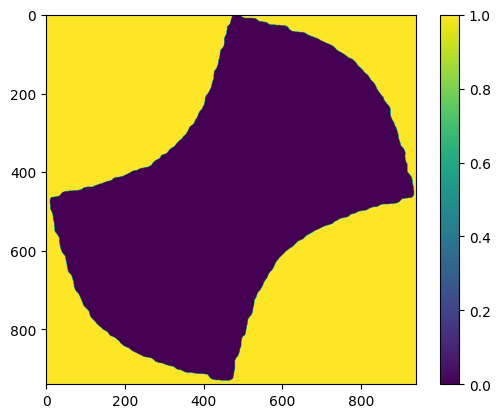

Iteration: 1 / FoM: 0.20018315315246582 / Elapsed time: 2 s
Iteration: 2 / FoM: 0.2018938958644867 / Elapsed time: 3 s
Iteration: 3 / FoM: 0.205958291888237 / Elapsed time: 4 s
Iteration: 4 / FoM: 0.2090107500553131 / Elapsed time: 5 s
Iteration: 5 / FoM: 0.2127760499715805 / Elapsed time: 6 s
Iteration: 6 / FoM: 0.21570974588394165 / Elapsed time: 6 s
Iteration: 7 / FoM: 0.21779079735279083 / Elapsed time: 7 s
Iteration: 8 / FoM: 0.22061797976493835 / Elapsed time: 8 s
Iteration: 9 / FoM: 0.22365285456180573 / Elapsed time: 9 s
Iteration: 10 / FoM: 0.2270403951406479 / Elapsed time: 10 s
Iteration: 11 / FoM: 0.22893787920475006 / Elapsed time: 11 s
Iteration: 12 / FoM: 0.2327861189842224 / Elapsed time: 12 s
Iteration: 13 / FoM: 0.23461458086967468 / Elapsed time: 12 s
Iteration: 14 / FoM: 0.2381608784198761 / Elapsed time: 13 s
Iteration: 15 / FoM: 0.23963142931461334 / Elapsed time: 14 s
tensor([0.1628, 0.1170, 0.1327, 0.1206, 0.0397, 0.1272, 0.1308, 0.1224, 0.1639],
       device='

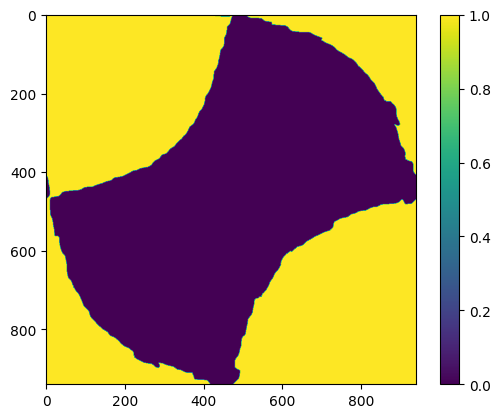

Iteration: 16 / FoM: 0.24219655990600586 / Elapsed time: 16 s
Iteration: 17 / FoM: 0.24658288061618805 / Elapsed time: 17 s
Iteration: 18 / FoM: 0.2487793117761612 / Elapsed time: 17 s
Iteration: 19 / FoM: 0.2517831027507782 / Elapsed time: 18 s
Iteration: 20 / FoM: 0.25360989570617676 / Elapsed time: 19 s
Iteration: 21 / FoM: 0.25663718581199646 / Elapsed time: 20 s
Iteration: 22 / FoM: 0.25979042053222656 / Elapsed time: 21 s
Iteration: 23 / FoM: 0.26141828298568726 / Elapsed time: 22 s
Iteration: 24 / FoM: 0.2645881175994873 / Elapsed time: 22 s
Iteration: 25 / FoM: 0.26677700877189636 / Elapsed time: 23 s
Iteration: 26 / FoM: 0.2679649293422699 / Elapsed time: 24 s
Iteration: 27 / FoM: 0.268885999917984 / Elapsed time: 25 s
Iteration: 28 / FoM: 0.2705537974834442 / Elapsed time: 26 s
Iteration: 29 / FoM: 0.27362677454948425 / Elapsed time: 27 s
Iteration: 30 / FoM: 0.2741905152797699 / Elapsed time: 27 s
tensor([0.1571, 0.1173, 0.1405, 0.1191, 0.0433, 0.1276, 0.1360, 0.1235, 0.1530

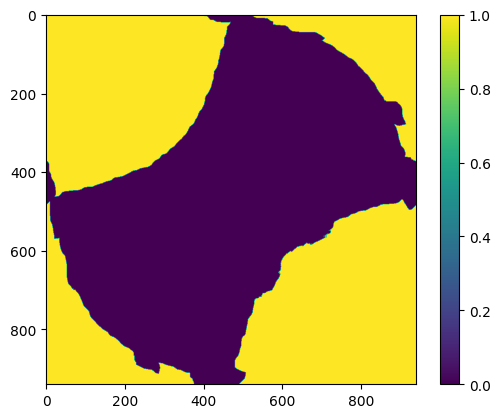

Iteration: 31 / FoM: 0.2761342227458954 / Elapsed time: 29 s
Iteration: 32 / FoM: 0.2762982249259949 / Elapsed time: 30 s
Iteration: 33 / FoM: 0.2774658501148224 / Elapsed time: 31 s
Iteration: 34 / FoM: 0.2797761559486389 / Elapsed time: 32 s
Iteration: 35 / FoM: 0.28098681569099426 / Elapsed time: 33 s
Iteration: 36 / FoM: 0.2793079614639282 / Elapsed time: 33 s
Iteration: 37 / FoM: 0.2820145785808563 / Elapsed time: 34 s
Iteration: 38 / FoM: 0.2810552716255188 / Elapsed time: 35 s
Iteration: 39 / FoM: 0.28299129009246826 / Elapsed time: 36 s
Iteration: 40 / FoM: 0.28231045603752136 / Elapsed time: 37 s
Iteration: 41 / FoM: 0.2833385765552521 / Elapsed time: 38 s
Iteration: 42 / FoM: 0.283151775598526 / Elapsed time: 38 s
Iteration: 43 / FoM: 0.2843266725540161 / Elapsed time: 39 s
Iteration: 44 / FoM: 0.2862837612628937 / Elapsed time: 40 s
Iteration: 45 / FoM: 0.2842055559158325 / Elapsed time: 41 s
tensor([0.1542, 0.1233, 0.1372, 0.1233, 0.0443, 0.1296, 0.1332, 0.1257, 0.1499],
  

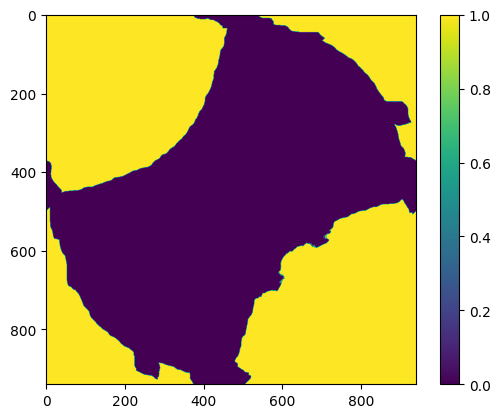

Iteration: 46 / FoM: 0.2857174873352051 / Elapsed time: 43 s
Iteration: 47 / FoM: 0.2873836159706116 / Elapsed time: 43 s
Iteration: 48 / FoM: 0.2879959046840668 / Elapsed time: 44 s
Iteration: 49 / FoM: 0.2854819595813751 / Elapsed time: 45 s
Iteration: 50 / FoM: 0.289415568113327 / Elapsed time: 46 s
Iteration: 51 / FoM: 0.2896595001220703 / Elapsed time: 47 s
Iteration: 52 / FoM: 0.28870436549186707 / Elapsed time: 47 s
Iteration: 53 / FoM: 0.29015982151031494 / Elapsed time: 48 s
Iteration: 54 / FoM: 0.28978803753852844 / Elapsed time: 49 s
Iteration: 55 / FoM: 0.29071757197380066 / Elapsed time: 50 s
Iteration: 56 / FoM: 0.2927393913269043 / Elapsed time: 51 s
Iteration: 57 / FoM: 0.2918655276298523 / Elapsed time: 52 s
Iteration: 58 / FoM: 0.29221901297569275 / Elapsed time: 52 s
Iteration: 59 / FoM: 0.2940647602081299 / Elapsed time: 53 s
Iteration: 60 / FoM: 0.2934926152229309 / Elapsed time: 54 s
tensor([0.1531, 0.1292, 0.1300, 0.1288, 0.0450, 0.1323, 0.1246, 0.1276, 0.1519],


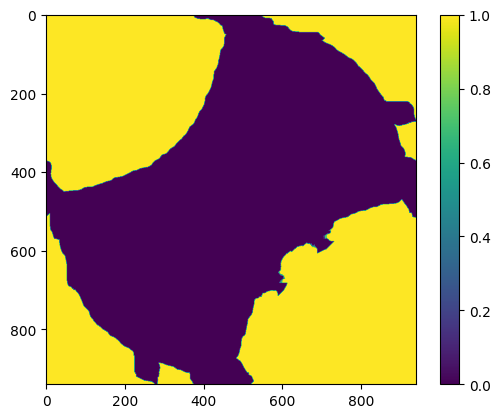

Iteration: 61 / FoM: 0.29401183128356934 / Elapsed time: 56 s
Iteration: 62 / FoM: 0.2955034077167511 / Elapsed time: 57 s
Iteration: 63 / FoM: 0.2951083183288574 / Elapsed time: 57 s
Iteration: 64 / FoM: 0.29461950063705444 / Elapsed time: 58 s
Iteration: 65 / FoM: 0.296413779258728 / Elapsed time: 59 s
Iteration: 66 / FoM: 0.297203004360199 / Elapsed time: 60 s
Iteration: 67 / FoM: 0.2953052818775177 / Elapsed time: 61 s
Iteration: 68 / FoM: 0.2952249348163605 / Elapsed time: 62 s
Iteration: 69 / FoM: 0.2950281798839569 / Elapsed time: 62 s
Iteration: 70 / FoM: 0.29665568470954895 / Elapsed time: 63 s
Iteration: 71 / FoM: 0.2957065999507904 / Elapsed time: 64 s
Iteration: 72 / FoM: 0.2943612337112427 / Elapsed time: 65 s
Iteration: 73 / FoM: 0.2957538068294525 / Elapsed time: 66 s
Iteration: 74 / FoM: 0.2954179644584656 / Elapsed time: 67 s
Iteration: 75 / FoM: 0.2984905242919922 / Elapsed time: 67 s
tensor([0.1499, 0.1359, 0.1098, 0.1349, 0.0473, 0.1348, 0.1070, 0.1306, 0.1589],
   

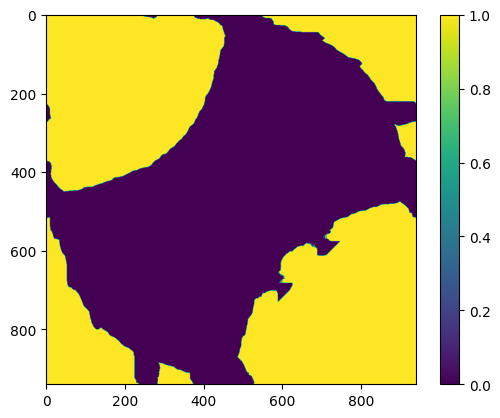

Iteration: 76 / FoM: 0.297705739736557 / Elapsed time: 69 s
Iteration: 77 / FoM: 0.29878464341163635 / Elapsed time: 70 s
Iteration: 78 / FoM: 0.29903048276901245 / Elapsed time: 71 s
Iteration: 79 / FoM: 0.30011284351348877 / Elapsed time: 72 s
Iteration: 80 / FoM: 0.30002710223197937 / Elapsed time: 72 s
Iteration: 81 / FoM: 0.3038574457168579 / Elapsed time: 73 s
Iteration: 82 / FoM: 0.3043902516365051 / Elapsed time: 74 s
Iteration: 83 / FoM: 0.3100328743457794 / Elapsed time: 75 s
Iteration: 84 / FoM: 0.30872321128845215 / Elapsed time: 76 s
Iteration: 85 / FoM: 0.31229907274246216 / Elapsed time: 76 s
Iteration: 86 / FoM: 0.3147537410259247 / Elapsed time: 77 s
Iteration: 87 / FoM: 0.3213634490966797 / Elapsed time: 78 s
Iteration: 88 / FoM: 0.32365894317626953 / Elapsed time: 79 s
Iteration: 89 / FoM: 0.3308812975883484 / Elapsed time: 80 s
Iteration: 90 / FoM: 0.332649290561676 / Elapsed time: 81 s
tensor([0.1429, 0.1329, 0.1002, 0.1357, 0.0579, 0.1328, 0.1011, 0.1273, 0.1707],

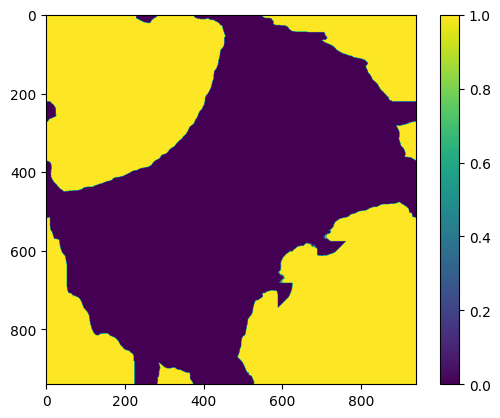

Iteration: 91 / FoM: 0.33941689133644104 / Elapsed time: 82 s
Iteration: 92 / FoM: 0.34239664673805237 / Elapsed time: 83 s
Iteration: 93 / FoM: 0.3504009246826172 / Elapsed time: 84 s
Iteration: 94 / FoM: 0.35466718673706055 / Elapsed time: 85 s
Iteration: 95 / FoM: 0.35754430294036865 / Elapsed time: 86 s
Iteration: 96 / FoM: 0.3633009195327759 / Elapsed time: 86 s
Iteration: 97 / FoM: 0.36655735969543457 / Elapsed time: 87 s
Iteration: 98 / FoM: 0.3714952766895294 / Elapsed time: 88 s
Iteration: 99 / FoM: 0.37417128682136536 / Elapsed time: 89 s
Iteration: 100 / FoM: 0.3817128837108612 / Elapsed time: 90 s
Iteration: 101 / FoM: 0.38061216473579407 / Elapsed time: 91 s
Iteration: 102 / FoM: 0.38692501187324524 / Elapsed time: 91 s
Iteration: 103 / FoM: 0.388933390378952 / Elapsed time: 92 s
Iteration: 104 / FoM: 0.39055928587913513 / Elapsed time: 93 s
Iteration: 105 / FoM: 0.39586809277534485 / Elapsed time: 94 s
tensor([0.1439, 0.1353, 0.1352, 0.1341, 0.0675, 0.1227, 0.1330, 0.1171

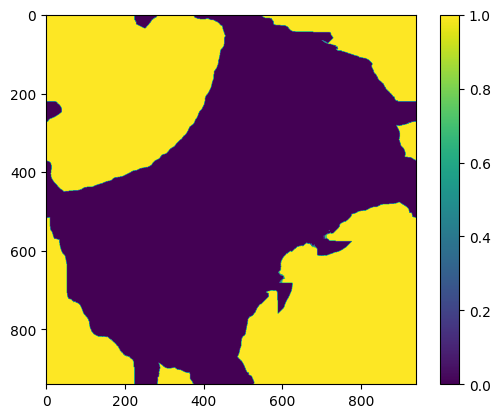

Iteration: 106 / FoM: 0.3979926109313965 / Elapsed time: 96 s
Iteration: 107 / FoM: 0.40022534132003784 / Elapsed time: 97 s
Iteration: 108 / FoM: 0.40345126390457153 / Elapsed time: 97 s
Iteration: 109 / FoM: 0.40752145648002625 / Elapsed time: 98 s
Iteration: 110 / FoM: 0.4093623459339142 / Elapsed time: 99 s
Iteration: 111 / FoM: 0.4087229073047638 / Elapsed time: 100 s
Iteration: 112 / FoM: 0.4099624454975128 / Elapsed time: 101 s
Iteration: 113 / FoM: 0.41531094908714294 / Elapsed time: 102 s
Iteration: 114 / FoM: 0.41284579038619995 / Elapsed time: 102 s
Iteration: 115 / FoM: 0.4187641143798828 / Elapsed time: 103 s
Iteration: 116 / FoM: 0.41521018743515015 / Elapsed time: 104 s
Iteration: 117 / FoM: 0.41447797417640686 / Elapsed time: 105 s
Iteration: 118 / FoM: 0.41705194115638733 / Elapsed time: 106 s
Iteration: 119 / FoM: 0.4180806875228882 / Elapsed time: 107 s
Iteration: 120 / FoM: 0.41718077659606934 / Elapsed time: 107 s
tensor([0.1445, 0.1440, 0.1353, 0.1425, 0.0730, 0.1

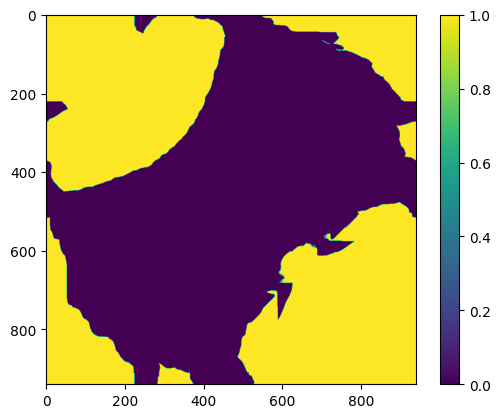

Iteration: 121 / FoM: 0.4195461869239807 / Elapsed time: 109 s
Iteration: 122 / FoM: 0.4210086166858673 / Elapsed time: 110 s
Iteration: 123 / FoM: 0.4186434745788574 / Elapsed time: 111 s
Iteration: 124 / FoM: 0.4156155288219452 / Elapsed time: 112 s
Iteration: 125 / FoM: 0.4122541546821594 / Elapsed time: 113 s
Iteration: 126 / FoM: 0.4142613410949707 / Elapsed time: 113 s
Iteration: 127 / FoM: 0.41094744205474854 / Elapsed time: 114 s
Iteration: 128 / FoM: 0.40901052951812744 / Elapsed time: 115 s
Iteration: 129 / FoM: 0.4086000919342041 / Elapsed time: 116 s
Iteration: 130 / FoM: 0.4065302014350891 / Elapsed time: 117 s
Iteration: 131 / FoM: 0.3995140492916107 / Elapsed time: 118 s
Iteration: 132 / FoM: 0.3986121118068695 / Elapsed time: 118 s
Iteration: 133 / FoM: 0.39648687839508057 / Elapsed time: 119 s
Iteration: 134 / FoM: 0.39264845848083496 / Elapsed time: 120 s
Iteration: 135 / FoM: 0.3889188766479492 / Elapsed time: 121 s
tensor([0.1346, 0.1505, 0.1334, 0.1459, 0.0753, 0.1

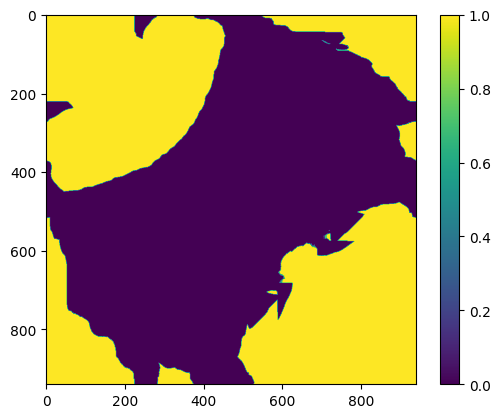

Iteration: 136 / FoM: 0.3837960362434387 / Elapsed time: 123 s
Iteration: 137 / FoM: 0.38035261631011963 / Elapsed time: 123 s
Iteration: 138 / FoM: 0.38023921847343445 / Elapsed time: 124 s
Iteration: 139 / FoM: 0.3709316551685333 / Elapsed time: 125 s
Iteration: 140 / FoM: 0.3712024688720703 / Elapsed time: 126 s
Iteration: 141 / FoM: 0.3647909164428711 / Elapsed time: 127 s
Iteration: 142 / FoM: 0.3594244420528412 / Elapsed time: 128 s
Iteration: 143 / FoM: 0.35448557138442993 / Elapsed time: 128 s
Iteration: 144 / FoM: 0.35064855217933655 / Elapsed time: 129 s
Iteration: 145 / FoM: 0.34679171442985535 / Elapsed time: 130 s
Iteration: 146 / FoM: 0.34051889181137085 / Elapsed time: 131 s
Iteration: 147 / FoM: 0.3385106027126312 / Elapsed time: 132 s
Iteration: 148 / FoM: 0.3343290090560913 / Elapsed time: 133 s
Iteration: 149 / FoM: 0.32831913232803345 / Elapsed time: 133 s
Iteration: 150 / FoM: 0.3253326416015625 / Elapsed time: 134 s
tensor([0.1283, 0.1521, 0.1344, 0.1504, 0.0696, 

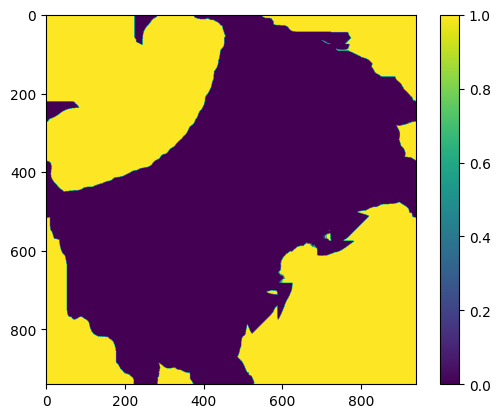

Iteration: 151 / FoM: 0.3210868835449219 / Elapsed time: 136 s
Iteration: 152 / FoM: 0.3161185681819916 / Elapsed time: 137 s
Iteration: 153 / FoM: 0.3132401704788208 / Elapsed time: 138 s
Iteration: 154 / FoM: 0.3096889853477478 / Elapsed time: 139 s
Iteration: 155 / FoM: 0.3050318658351898 / Elapsed time: 139 s
Iteration: 156 / FoM: 0.30336177349090576 / Elapsed time: 140 s
Iteration: 157 / FoM: 0.2979797124862671 / Elapsed time: 141 s
Iteration: 158 / FoM: 0.2952146530151367 / Elapsed time: 142 s
Iteration: 159 / FoM: 0.29224708676338196 / Elapsed time: 143 s
Iteration: 160 / FoM: 0.2896103262901306 / Elapsed time: 144 s
Iteration: 161 / FoM: 0.2867467701435089 / Elapsed time: 145 s
Iteration: 162 / FoM: 0.28397390246391296 / Elapsed time: 145 s
Iteration: 163 / FoM: 0.28059121966362 / Elapsed time: 146 s
Iteration: 164 / FoM: 0.2790856659412384 / Elapsed time: 147 s
Iteration: 165 / FoM: 0.2765887677669525 / Elapsed time: 148 s
tensor([0.1349, 0.1517, 0.1306, 0.1570, 0.0602, 0.1293

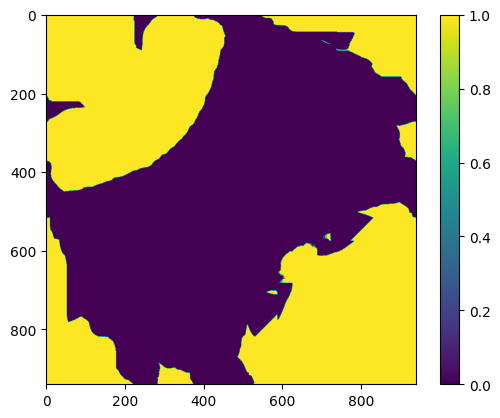

Iteration: 166 / FoM: 0.27519696950912476 / Elapsed time: 150 s
Iteration: 167 / FoM: 0.2708131968975067 / Elapsed time: 150 s
Iteration: 168 / FoM: 0.2712542712688446 / Elapsed time: 151 s
Iteration: 169 / FoM: 0.26871541142463684 / Elapsed time: 152 s
Iteration: 170 / FoM: 0.26818254590034485 / Elapsed time: 153 s
Iteration: 171 / FoM: 0.26687467098236084 / Elapsed time: 154 s
Iteration: 172 / FoM: 0.2646242678165436 / Elapsed time: 155 s
Iteration: 173 / FoM: 0.2642885744571686 / Elapsed time: 156 s
Iteration: 174 / FoM: 0.26344767212867737 / Elapsed time: 156 s
Iteration: 175 / FoM: 0.2631717026233673 / Elapsed time: 157 s
Iteration: 176 / FoM: 0.2624073028564453 / Elapsed time: 158 s
Iteration: 177 / FoM: 0.26106682419776917 / Elapsed time: 159 s
Iteration: 178 / FoM: 0.2598623037338257 / Elapsed time: 160 s
Iteration: 179 / FoM: 0.26121777296066284 / Elapsed time: 161 s
Iteration: 180 / FoM: 0.26110130548477173 / Elapsed time: 161 s
tensor([0.1432, 0.1528, 0.1243, 0.1607, 0.0557,

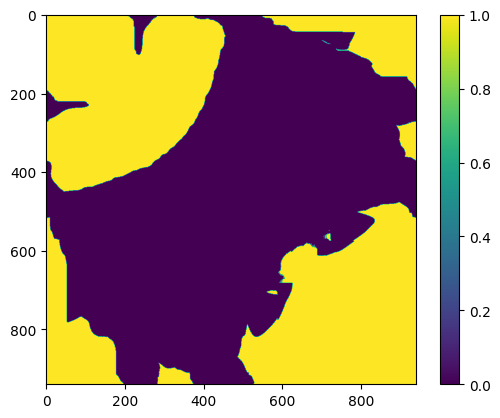

Iteration: 181 / FoM: 0.2625170052051544 / Elapsed time: 163 s
Iteration: 182 / FoM: 0.26399973034858704 / Elapsed time: 164 s
Iteration: 183 / FoM: 0.26339617371559143 / Elapsed time: 165 s
Iteration: 184 / FoM: 0.2659021019935608 / Elapsed time: 166 s
Iteration: 185 / FoM: 0.2670358717441559 / Elapsed time: 167 s
Iteration: 186 / FoM: 0.2686080038547516 / Elapsed time: 167 s
Iteration: 187 / FoM: 0.269960880279541 / Elapsed time: 168 s
Iteration: 188 / FoM: 0.26909640431404114 / Elapsed time: 169 s
Iteration: 189 / FoM: 0.2707931399345398 / Elapsed time: 170 s
Iteration: 190 / FoM: 0.2706749141216278 / Elapsed time: 171 s
Iteration: 191 / FoM: 0.2700677812099457 / Elapsed time: 172 s
Iteration: 192 / FoM: 0.2694765627384186 / Elapsed time: 173 s
Iteration: 193 / FoM: 0.2694765627384186 / Elapsed time: 173 s
Iteration: 194 / FoM: 0.2694765627384186 / Elapsed time: 174 s
Iteration: 195 / FoM: 0.2694765627384186 / Elapsed time: 175 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.126

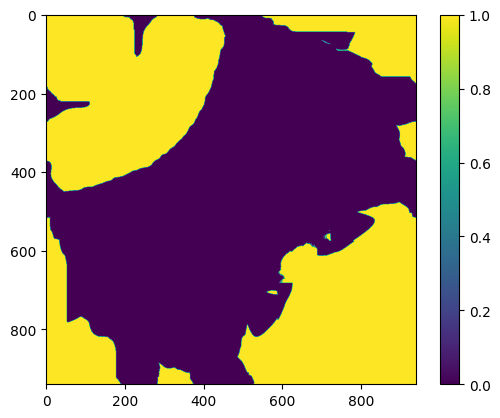

Iteration: 196 / FoM: 0.2694765627384186 / Elapsed time: 177 s
Iteration: 197 / FoM: 0.2694765627384186 / Elapsed time: 178 s
Iteration: 198 / FoM: 0.2694765627384186 / Elapsed time: 178 s
Iteration: 199 / FoM: 0.2694765627384186 / Elapsed time: 179 s
Iteration: 200 / FoM: 0.2694765627384186 / Elapsed time: 180 s
Iteration: 201 / FoM: 0.2694765627384186 / Elapsed time: 181 s
Iteration: 202 / FoM: 0.2694765627384186 / Elapsed time: 182 s
Iteration: 203 / FoM: 0.2694765627384186 / Elapsed time: 183 s
Iteration: 204 / FoM: 0.2694765627384186 / Elapsed time: 183 s
Iteration: 205 / FoM: 0.2694765627384186 / Elapsed time: 184 s
Iteration: 206 / FoM: 0.2694765627384186 / Elapsed time: 185 s
Iteration: 207 / FoM: 0.2694765627384186 / Elapsed time: 186 s
Iteration: 208 / FoM: 0.2694765627384186 / Elapsed time: 187 s
Iteration: 209 / FoM: 0.2694765627384186 / Elapsed time: 188 s
Iteration: 210 / FoM: 0.2694765627384186 / Elapsed time: 188 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

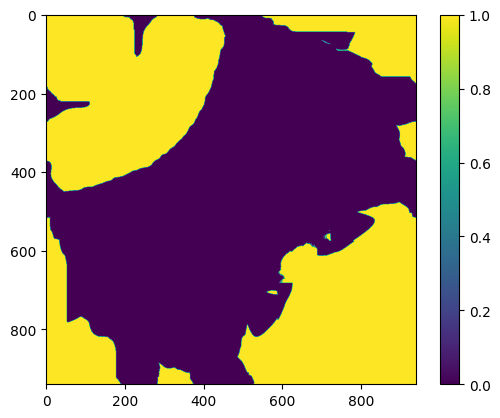

Iteration: 211 / FoM: 0.2694765627384186 / Elapsed time: 190 s
Iteration: 212 / FoM: 0.2694765627384186 / Elapsed time: 191 s
Iteration: 213 / FoM: 0.2694765627384186 / Elapsed time: 192 s
Iteration: 214 / FoM: 0.2694765627384186 / Elapsed time: 193 s
Iteration: 215 / FoM: 0.2694765627384186 / Elapsed time: 194 s
Iteration: 216 / FoM: 0.2694765627384186 / Elapsed time: 194 s
Iteration: 217 / FoM: 0.2694765627384186 / Elapsed time: 195 s
Iteration: 218 / FoM: 0.2694765627384186 / Elapsed time: 196 s
Iteration: 219 / FoM: 0.2694765627384186 / Elapsed time: 197 s
Iteration: 220 / FoM: 0.2694765627384186 / Elapsed time: 198 s
Iteration: 221 / FoM: 0.2694765627384186 / Elapsed time: 199 s
Iteration: 222 / FoM: 0.2694765627384186 / Elapsed time: 200 s
Iteration: 223 / FoM: 0.2694765627384186 / Elapsed time: 201 s
Iteration: 224 / FoM: 0.2694765627384186 / Elapsed time: 201 s
Iteration: 225 / FoM: 0.2694765627384186 / Elapsed time: 202 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

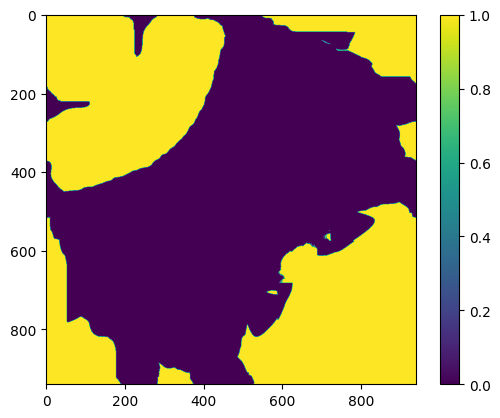

Iteration: 226 / FoM: 0.2694765627384186 / Elapsed time: 204 s
Iteration: 227 / FoM: 0.2694765627384186 / Elapsed time: 205 s
Iteration: 228 / FoM: 0.2694765627384186 / Elapsed time: 206 s
Iteration: 229 / FoM: 0.2694765627384186 / Elapsed time: 207 s
Iteration: 230 / FoM: 0.2694765627384186 / Elapsed time: 208 s
Iteration: 231 / FoM: 0.2694765627384186 / Elapsed time: 208 s
Iteration: 232 / FoM: 0.2694765627384186 / Elapsed time: 209 s
Iteration: 233 / FoM: 0.2694765627384186 / Elapsed time: 210 s
Iteration: 234 / FoM: 0.2694765627384186 / Elapsed time: 211 s
Iteration: 235 / FoM: 0.2694765627384186 / Elapsed time: 212 s
Iteration: 236 / FoM: 0.2694765627384186 / Elapsed time: 213 s
Iteration: 237 / FoM: 0.2694765627384186 / Elapsed time: 214 s
Iteration: 238 / FoM: 0.2694765627384186 / Elapsed time: 214 s
Iteration: 239 / FoM: 0.2694765627384186 / Elapsed time: 215 s
Iteration: 240 / FoM: 0.2694765627384186 / Elapsed time: 216 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

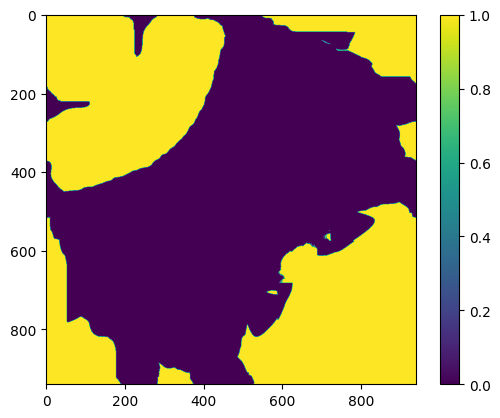

Iteration: 241 / FoM: 0.2694765627384186 / Elapsed time: 218 s
Iteration: 242 / FoM: 0.2694765627384186 / Elapsed time: 219 s
Iteration: 243 / FoM: 0.2694765627384186 / Elapsed time: 220 s
Iteration: 244 / FoM: 0.2694765627384186 / Elapsed time: 221 s
Iteration: 245 / FoM: 0.2694765627384186 / Elapsed time: 221 s
Iteration: 246 / FoM: 0.2694765627384186 / Elapsed time: 222 s
Iteration: 247 / FoM: 0.2694765627384186 / Elapsed time: 223 s
Iteration: 248 / FoM: 0.2694765627384186 / Elapsed time: 224 s
Iteration: 249 / FoM: 0.2694765627384186 / Elapsed time: 225 s
Iteration: 250 / FoM: 0.2694765627384186 / Elapsed time: 226 s
Iteration: 251 / FoM: 0.2694765627384186 / Elapsed time: 226 s
Iteration: 252 / FoM: 0.2694765627384186 / Elapsed time: 227 s
Iteration: 253 / FoM: 0.2694765627384186 / Elapsed time: 228 s
Iteration: 254 / FoM: 0.2694765627384186 / Elapsed time: 229 s
Iteration: 255 / FoM: 0.2694765627384186 / Elapsed time: 230 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

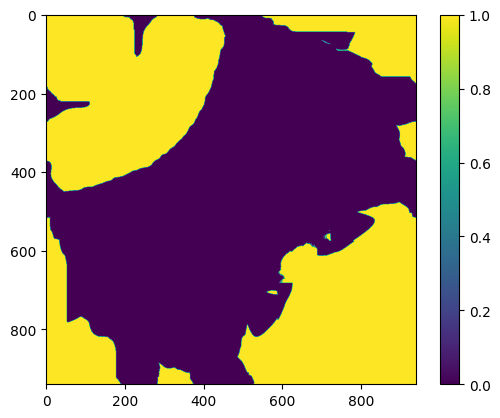

Iteration: 256 / FoM: 0.2694765627384186 / Elapsed time: 232 s
Iteration: 257 / FoM: 0.2694765627384186 / Elapsed time: 233 s
Iteration: 258 / FoM: 0.2694765627384186 / Elapsed time: 233 s
Iteration: 259 / FoM: 0.2694765627384186 / Elapsed time: 234 s
Iteration: 260 / FoM: 0.2694765627384186 / Elapsed time: 235 s
Iteration: 261 / FoM: 0.2694765627384186 / Elapsed time: 236 s
Iteration: 262 / FoM: 0.2694765627384186 / Elapsed time: 237 s
Iteration: 263 / FoM: 0.2694765627384186 / Elapsed time: 238 s
Iteration: 264 / FoM: 0.2694765627384186 / Elapsed time: 239 s
Iteration: 265 / FoM: 0.2694765627384186 / Elapsed time: 240 s
Iteration: 266 / FoM: 0.2694765627384186 / Elapsed time: 240 s
Iteration: 267 / FoM: 0.2694765627384186 / Elapsed time: 241 s
Iteration: 268 / FoM: 0.2694765627384186 / Elapsed time: 242 s
Iteration: 269 / FoM: 0.2694765627384186 / Elapsed time: 243 s
Iteration: 270 / FoM: 0.2694765627384186 / Elapsed time: 244 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

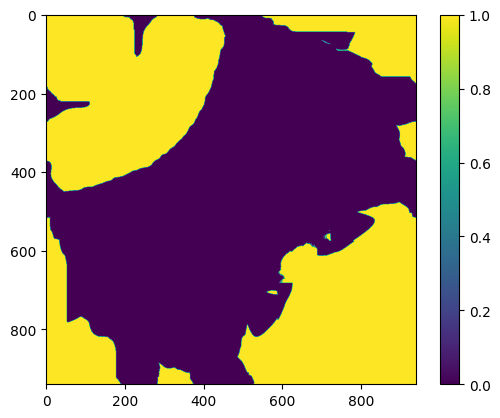

Iteration: 271 / FoM: 0.2694765627384186 / Elapsed time: 246 s
Iteration: 272 / FoM: 0.2694765627384186 / Elapsed time: 247 s
Iteration: 273 / FoM: 0.2694765627384186 / Elapsed time: 247 s
Iteration: 274 / FoM: 0.2694765627384186 / Elapsed time: 248 s
Iteration: 275 / FoM: 0.2694765627384186 / Elapsed time: 249 s
Iteration: 276 / FoM: 0.2694765627384186 / Elapsed time: 250 s
Iteration: 277 / FoM: 0.2694765627384186 / Elapsed time: 251 s
Iteration: 278 / FoM: 0.2694765627384186 / Elapsed time: 252 s
Iteration: 279 / FoM: 0.2694765627384186 / Elapsed time: 252 s
Iteration: 280 / FoM: 0.2694765627384186 / Elapsed time: 253 s
Iteration: 281 / FoM: 0.2694765627384186 / Elapsed time: 254 s
Iteration: 282 / FoM: 0.2694765627384186 / Elapsed time: 255 s
Iteration: 283 / FoM: 0.2694765627384186 / Elapsed time: 256 s
Iteration: 284 / FoM: 0.2694765627384186 / Elapsed time: 257 s
Iteration: 285 / FoM: 0.2694765627384186 / Elapsed time: 257 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

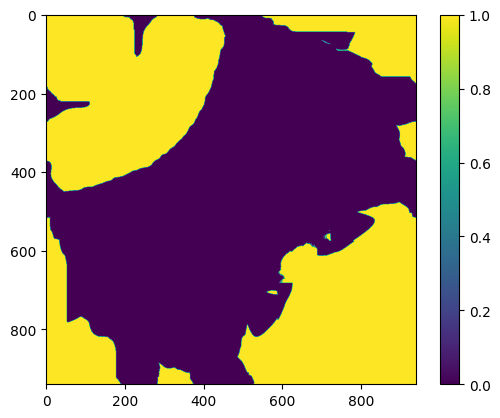

Iteration: 286 / FoM: 0.2694765627384186 / Elapsed time: 259 s
Iteration: 287 / FoM: 0.2694765627384186 / Elapsed time: 260 s
Iteration: 288 / FoM: 0.2694765627384186 / Elapsed time: 261 s
Iteration: 289 / FoM: 0.2694765627384186 / Elapsed time: 262 s
Iteration: 290 / FoM: 0.2694765627384186 / Elapsed time: 262 s
Iteration: 291 / FoM: 0.2694765627384186 / Elapsed time: 263 s
Iteration: 292 / FoM: 0.2694765627384186 / Elapsed time: 264 s
Iteration: 293 / FoM: 0.2694765627384186 / Elapsed time: 265 s
Iteration: 294 / FoM: 0.2694765627384186 / Elapsed time: 266 s
Iteration: 295 / FoM: 0.2694765627384186 / Elapsed time: 267 s
Iteration: 296 / FoM: 0.2694765627384186 / Elapsed time: 267 s
Iteration: 297 / FoM: 0.2694765627384186 / Elapsed time: 268 s
Iteration: 298 / FoM: 0.2694765627384186 / Elapsed time: 269 s
Iteration: 299 / FoM: 0.2694765627384186 / Elapsed time: 270 s
Iteration: 300 / FoM: 0.2694765627384186 / Elapsed time: 271 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

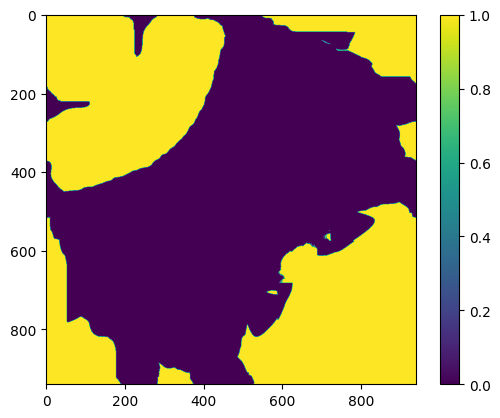

Iteration: 301 / FoM: 0.2694765627384186 / Elapsed time: 273 s
Iteration: 302 / FoM: 0.2694765627384186 / Elapsed time: 273 s
Iteration: 303 / FoM: 0.2694765627384186 / Elapsed time: 274 s
Iteration: 304 / FoM: 0.2694765627384186 / Elapsed time: 275 s
Iteration: 305 / FoM: 0.2694765627384186 / Elapsed time: 276 s
Iteration: 306 / FoM: 0.2694765627384186 / Elapsed time: 277 s
Iteration: 307 / FoM: 0.2694765627384186 / Elapsed time: 278 s
Iteration: 308 / FoM: 0.2694765627384186 / Elapsed time: 278 s
Iteration: 309 / FoM: 0.2694765627384186 / Elapsed time: 279 s
Iteration: 310 / FoM: 0.2694765627384186 / Elapsed time: 280 s
Iteration: 311 / FoM: 0.2694765627384186 / Elapsed time: 281 s
Iteration: 312 / FoM: 0.2694765627384186 / Elapsed time: 282 s
Iteration: 313 / FoM: 0.2694765627384186 / Elapsed time: 283 s
Iteration: 314 / FoM: 0.2694765627384186 / Elapsed time: 283 s
Iteration: 315 / FoM: 0.2694765627384186 / Elapsed time: 284 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

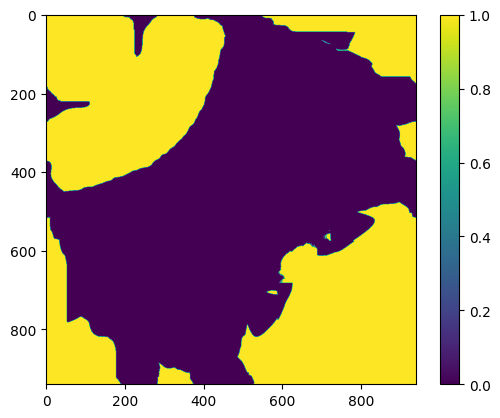

Iteration: 316 / FoM: 0.2694765627384186 / Elapsed time: 286 s
Iteration: 317 / FoM: 0.2694765627384186 / Elapsed time: 287 s
Iteration: 318 / FoM: 0.2694765627384186 / Elapsed time: 288 s
Iteration: 319 / FoM: 0.2694765627384186 / Elapsed time: 288 s
Iteration: 320 / FoM: 0.2694765627384186 / Elapsed time: 289 s
Iteration: 321 / FoM: 0.2694765627384186 / Elapsed time: 290 s
Iteration: 322 / FoM: 0.2694765627384186 / Elapsed time: 291 s
Iteration: 323 / FoM: 0.2694765627384186 / Elapsed time: 292 s
Iteration: 324 / FoM: 0.2694765627384186 / Elapsed time: 293 s
Iteration: 325 / FoM: 0.2694765627384186 / Elapsed time: 294 s
Iteration: 326 / FoM: 0.2694765627384186 / Elapsed time: 294 s
Iteration: 327 / FoM: 0.2694765627384186 / Elapsed time: 295 s
Iteration: 328 / FoM: 0.2694765627384186 / Elapsed time: 296 s
Iteration: 329 / FoM: 0.2694765627384186 / Elapsed time: 297 s
Iteration: 330 / FoM: 0.2694765627384186 / Elapsed time: 298 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

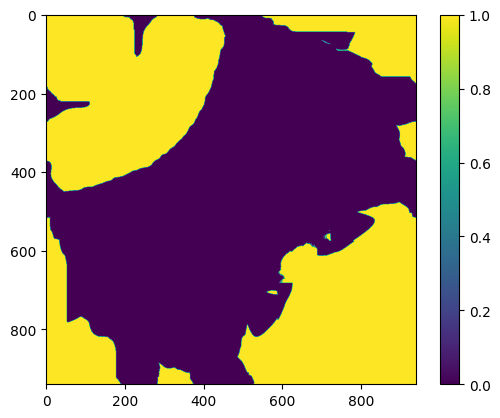

Iteration: 331 / FoM: 0.2694765627384186 / Elapsed time: 299 s
Iteration: 332 / FoM: 0.2694765627384186 / Elapsed time: 300 s
Iteration: 333 / FoM: 0.2694765627384186 / Elapsed time: 301 s
Iteration: 334 / FoM: 0.2694765627384186 / Elapsed time: 302 s
Iteration: 335 / FoM: 0.2694765627384186 / Elapsed time: 303 s
Iteration: 336 / FoM: 0.2694765627384186 / Elapsed time: 304 s
Iteration: 337 / FoM: 0.2694765627384186 / Elapsed time: 304 s
Iteration: 338 / FoM: 0.2694765627384186 / Elapsed time: 305 s
Iteration: 339 / FoM: 0.2694765627384186 / Elapsed time: 306 s
Iteration: 340 / FoM: 0.2694765627384186 / Elapsed time: 307 s
Iteration: 341 / FoM: 0.2694765627384186 / Elapsed time: 308 s
Iteration: 342 / FoM: 0.2694765627384186 / Elapsed time: 309 s
Iteration: 343 / FoM: 0.2694765627384186 / Elapsed time: 310 s
Iteration: 344 / FoM: 0.2694765627384186 / Elapsed time: 310 s
Iteration: 345 / FoM: 0.2694765627384186 / Elapsed time: 311 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

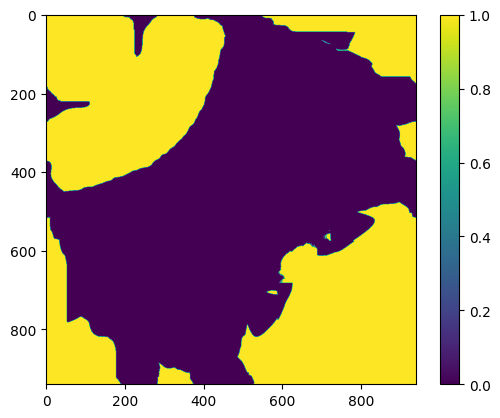

Iteration: 346 / FoM: 0.2694765627384186 / Elapsed time: 313 s
Iteration: 347 / FoM: 0.2694765627384186 / Elapsed time: 314 s
Iteration: 348 / FoM: 0.2694765627384186 / Elapsed time: 315 s
Iteration: 349 / FoM: 0.2694765627384186 / Elapsed time: 315 s
Iteration: 350 / FoM: 0.2694765627384186 / Elapsed time: 316 s
Iteration: 351 / FoM: 0.2694765627384186 / Elapsed time: 317 s
Iteration: 352 / FoM: 0.2694765627384186 / Elapsed time: 318 s
Iteration: 353 / FoM: 0.2694765627384186 / Elapsed time: 319 s
Iteration: 354 / FoM: 0.2694765627384186 / Elapsed time: 320 s
Iteration: 355 / FoM: 0.2694765627384186 / Elapsed time: 320 s
Iteration: 356 / FoM: 0.2694765627384186 / Elapsed time: 321 s
Iteration: 357 / FoM: 0.2694765627384186 / Elapsed time: 322 s
Iteration: 358 / FoM: 0.2694765627384186 / Elapsed time: 323 s
Iteration: 359 / FoM: 0.2694765627384186 / Elapsed time: 324 s
Iteration: 360 / FoM: 0.2694765627384186 / Elapsed time: 325 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

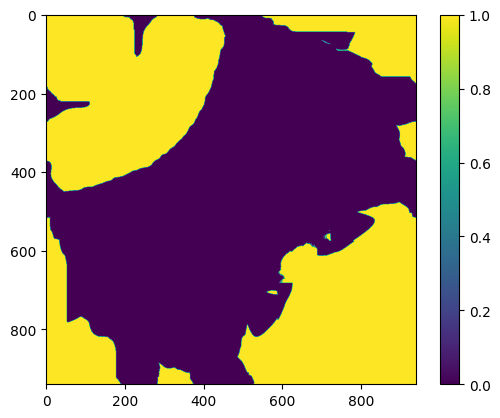

Iteration: 361 / FoM: 0.2694765627384186 / Elapsed time: 326 s
Iteration: 362 / FoM: 0.2694765627384186 / Elapsed time: 327 s
Iteration: 363 / FoM: 0.2694765627384186 / Elapsed time: 328 s
Iteration: 364 / FoM: 0.2694765627384186 / Elapsed time: 329 s
Iteration: 365 / FoM: 0.2694765627384186 / Elapsed time: 330 s
Iteration: 366 / FoM: 0.2694765627384186 / Elapsed time: 331 s
Iteration: 367 / FoM: 0.2694765627384186 / Elapsed time: 331 s
Iteration: 368 / FoM: 0.2694765627384186 / Elapsed time: 332 s
Iteration: 369 / FoM: 0.2694765627384186 / Elapsed time: 333 s
Iteration: 370 / FoM: 0.2694765627384186 / Elapsed time: 334 s
Iteration: 371 / FoM: 0.2694765627384186 / Elapsed time: 335 s
Iteration: 372 / FoM: 0.2694765627384186 / Elapsed time: 336 s
Iteration: 373 / FoM: 0.2694765627384186 / Elapsed time: 336 s
Iteration: 374 / FoM: 0.2694765627384186 / Elapsed time: 337 s
Iteration: 375 / FoM: 0.2694765627384186 / Elapsed time: 338 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

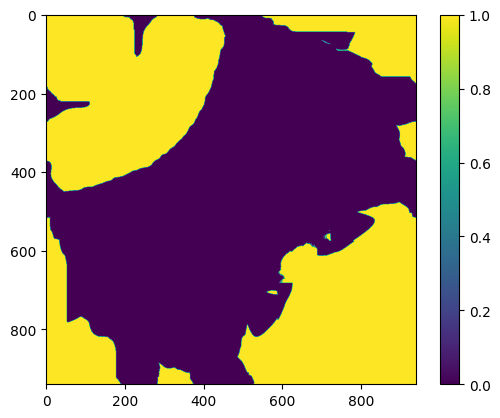

Iteration: 376 / FoM: 0.2694765627384186 / Elapsed time: 340 s
Iteration: 377 / FoM: 0.2694765627384186 / Elapsed time: 341 s
Iteration: 378 / FoM: 0.2694765627384186 / Elapsed time: 341 s
Iteration: 379 / FoM: 0.2694765627384186 / Elapsed time: 342 s
Iteration: 380 / FoM: 0.2694765627384186 / Elapsed time: 343 s
Iteration: 381 / FoM: 0.2694765627384186 / Elapsed time: 344 s
Iteration: 382 / FoM: 0.2694765627384186 / Elapsed time: 345 s
Iteration: 383 / FoM: 0.2694765627384186 / Elapsed time: 346 s
Iteration: 384 / FoM: 0.2694765627384186 / Elapsed time: 346 s
Iteration: 385 / FoM: 0.2694765627384186 / Elapsed time: 347 s
Iteration: 386 / FoM: 0.2694765627384186 / Elapsed time: 348 s
Iteration: 387 / FoM: 0.2694765627384186 / Elapsed time: 349 s
Iteration: 388 / FoM: 0.2694765627384186 / Elapsed time: 350 s
Iteration: 389 / FoM: 0.2694765627384186 / Elapsed time: 351 s
Iteration: 390 / FoM: 0.2694765627384186 / Elapsed time: 352 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

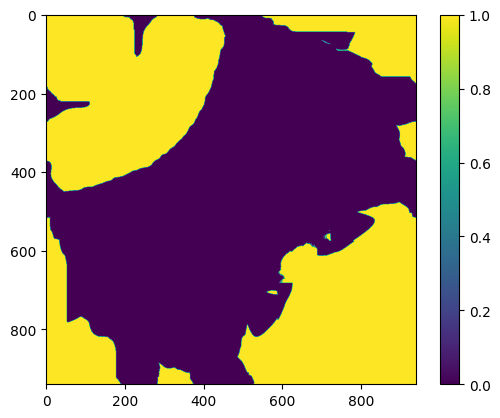

Iteration: 391 / FoM: 0.2694765627384186 / Elapsed time: 353 s
Iteration: 392 / FoM: 0.2694765627384186 / Elapsed time: 354 s
Iteration: 393 / FoM: 0.2694765627384186 / Elapsed time: 355 s
Iteration: 394 / FoM: 0.2694765627384186 / Elapsed time: 356 s
Iteration: 395 / FoM: 0.2694765627384186 / Elapsed time: 357 s
Iteration: 396 / FoM: 0.2694765627384186 / Elapsed time: 358 s
Iteration: 397 / FoM: 0.2694765627384186 / Elapsed time: 358 s
Iteration: 398 / FoM: 0.2694765627384186 / Elapsed time: 359 s
Iteration: 399 / FoM: 0.2694765627384186 / Elapsed time: 360 s
Iteration: 400 / FoM: 0.2694765627384186 / Elapsed time: 361 s
Iteration: 401 / FoM: 0.2694765627384186 / Elapsed time: 362 s
Iteration: 402 / FoM: 0.2694765627384186 / Elapsed time: 363 s
Iteration: 403 / FoM: 0.2694765627384186 / Elapsed time: 364 s
Iteration: 404 / FoM: 0.2694765627384186 / Elapsed time: 364 s
Iteration: 405 / FoM: 0.2694765627384186 / Elapsed time: 365 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

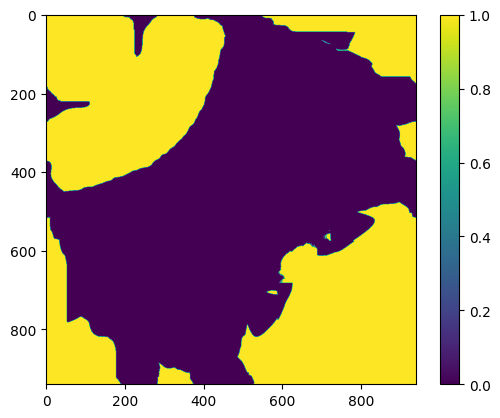

Iteration: 406 / FoM: 0.2694765627384186 / Elapsed time: 367 s
Iteration: 407 / FoM: 0.2694765627384186 / Elapsed time: 368 s
Iteration: 408 / FoM: 0.2694765627384186 / Elapsed time: 369 s
Iteration: 409 / FoM: 0.2694765627384186 / Elapsed time: 369 s
Iteration: 410 / FoM: 0.2694765627384186 / Elapsed time: 370 s
Iteration: 411 / FoM: 0.2694765627384186 / Elapsed time: 371 s
Iteration: 412 / FoM: 0.2694765627384186 / Elapsed time: 372 s
Iteration: 413 / FoM: 0.2694765627384186 / Elapsed time: 373 s
Iteration: 414 / FoM: 0.2694765627384186 / Elapsed time: 374 s
Iteration: 415 / FoM: 0.2694765627384186 / Elapsed time: 375 s
Iteration: 416 / FoM: 0.2694765627384186 / Elapsed time: 375 s
Iteration: 417 / FoM: 0.2694765627384186 / Elapsed time: 376 s
Iteration: 418 / FoM: 0.2694765627384186 / Elapsed time: 377 s
Iteration: 419 / FoM: 0.2694765627384186 / Elapsed time: 378 s
Iteration: 420 / FoM: 0.2694765627384186 / Elapsed time: 379 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

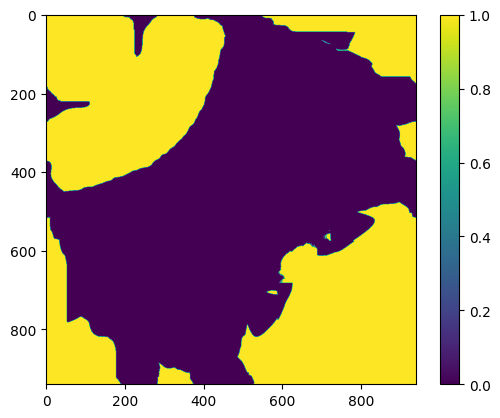

Iteration: 421 / FoM: 0.2694765627384186 / Elapsed time: 380 s
Iteration: 422 / FoM: 0.2694765627384186 / Elapsed time: 381 s
Iteration: 423 / FoM: 0.2694765627384186 / Elapsed time: 382 s
Iteration: 424 / FoM: 0.2694765627384186 / Elapsed time: 383 s
Iteration: 425 / FoM: 0.2694765627384186 / Elapsed time: 384 s
Iteration: 426 / FoM: 0.2694765627384186 / Elapsed time: 385 s
Iteration: 427 / FoM: 0.2694765627384186 / Elapsed time: 385 s
Iteration: 428 / FoM: 0.2694765627384186 / Elapsed time: 386 s
Iteration: 429 / FoM: 0.2694765627384186 / Elapsed time: 387 s
Iteration: 430 / FoM: 0.2694765627384186 / Elapsed time: 388 s
Iteration: 431 / FoM: 0.2694765627384186 / Elapsed time: 389 s
Iteration: 432 / FoM: 0.2694765627384186 / Elapsed time: 390 s
Iteration: 433 / FoM: 0.2694765627384186 / Elapsed time: 390 s
Iteration: 434 / FoM: 0.2694765627384186 / Elapsed time: 391 s
Iteration: 435 / FoM: 0.2694765627384186 / Elapsed time: 392 s
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265,

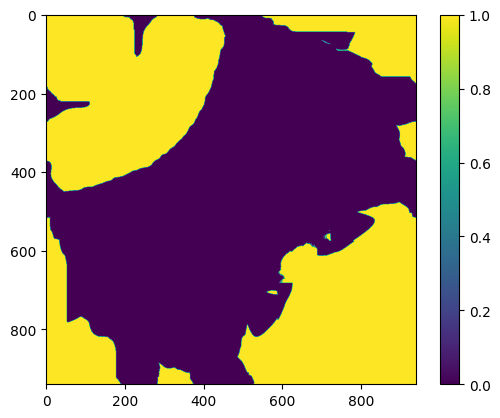

Iteration: 436 / FoM: 0.2694765627384186 / Elapsed time: 394 s
Iteration: 437 / FoM: 0.2694765627384186 / Elapsed time: 395 s
Iteration: 438 / FoM: 0.2694765627384186 / Elapsed time: 396 s
Iteration: 439 / FoM: 0.2694765627384186 / Elapsed time: 396 s
Iteration: 440 / FoM: 0.2694765627384186 / Elapsed time: 397 s
Iteration: 441 / FoM: 0.2694765627384186 / Elapsed time: 398 s
Iteration: 442 / FoM: 0.2694765627384186 / Elapsed time: 399 s
Iteration: 443 / FoM: 0.2694765627384186 / Elapsed time: 400 s
Iteration: 444 / FoM: 0.2694765627384186 / Elapsed time: 401 s
Iteration: 445 / FoM: 0.2694765627384186 / Elapsed time: 401 s
Iteration: 446 / FoM: 0.2694765627384186 / Elapsed time: 402 s
Iteration: 447 / FoM: 0.2694765627384186 / Elapsed time: 403 s
Iteration: 448 / FoM: 0.2694765627384186 / Elapsed time: 404 s
Iteration: 449 / FoM: 0.2694765627384186 / Elapsed time: 405 s


In [66]:
# Perform optimization
# optimizer parameters for ADAM optimizer
gar_initial = 0.01
beta1 = 0.9
beta2 = 0.9
epsilon = 1.e-8
iter_max = 450
beta = np.exp(np.arange(start=0,stop=iter_max)*np.log(1000)/iter_max)
gar = gar_initial * 0.5*(1+np.cos(np.arange(start=0,stop=iter_max)*np.pi/iter_max))
gar = 0.1
torch.manual_seed(333)
import cv2
image_path = 'Paper_patern.bmp'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (940, 940))

# Convert image to tensor
rho = torch.tensor(image_resized, dtype=torch.float32, device=device) / 255.0
rho[rho>=0.5] = 1
rho[rho<0.5]  = 0
momentum = torch.zeros_like(rho)
velocity = torch.zeros_like(rho)

rho_history = []
FoM_history = []

start_time = time.time()
for it in range(0,iter_max):
    rho.requires_grad_(True)
    rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho-beta[it])/(2*np.math.tanh(beta[it]))

    FoM = objective_function(rho_tilda)
    FoM.backward()

    with torch.no_grad():
        rho_gradient = rho.grad
        rho.grad = None

        rho_history.append(rho_tilda.detach().cpu().numpy())
        FoM = float(FoM.detach().cpu().numpy())
        FoM_history.append(FoM)

        momentum = (beta1*momentum + (1-beta1)*rho_gradient)
        velocity = (beta2*velocity + (1-beta2)*(rho_gradient**2))

        momentum_hat = (momentum / (1-beta1**(it+1)))
        velocity_hat = (velocity / (1-beta2**(it+1)))

        drho_dx = torch.abs( rho - torch.roll(rho, shifts=(0, 1), dims=(0, 1)))
        drho_dy = torch.abs( rho - torch.roll(rho, shifts=(1, 0), dims=(0, 1)))
        drho_dr = drho_dx + drho_dy
        drho_dr_binary = (drho_dr > 0)

        rho += gar* momentum_hat/ (torch.sqrt(velocity_hat) + epsilon) * drho_dr_binary
        rho[rho<0.9999] = 0
        rho[rho>0.0001] = 1
        #rho = (rho + torch.fliplr(rho))/2
        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Iteration:',it,'/ FoM:',FoM,'/ Elapsed time:',str(int(elapsed_time))+' s')
    if it%15 == 0:
        # Export data
        #filename = 'DOE3x3_topologic_data.mat'
        #ex6_data = {'rho_history':rho_history,'FoM_history':FoM_history}
        #scipy.io.savemat(filename,ex6_data)
        rho2 = rho.detach()
        #rho2[rho2>0.5] = 1
        #rho2[rho2<0.5] = 0
        # Plot
        print_order(rho2,layer0_thickness)
        plt.imshow(rho2.cpu().numpy())
        plt.colorbar()
        plt.show()

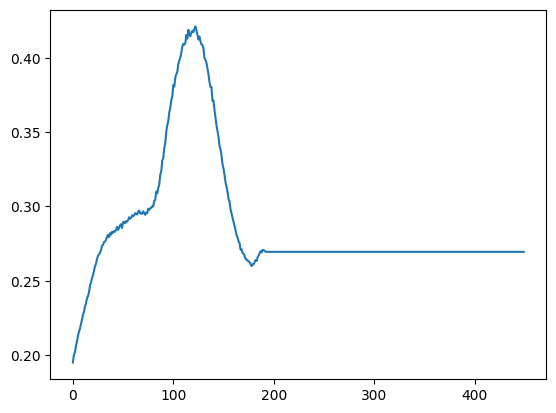

In [67]:
plt.plot(np.array(FoM_history))

0.26947656
THK = 235.0
tensor([0.1423, 0.1527, 0.1224, 0.1601, 0.0573, 0.1265, 0.1226, 0.1233, 0.2128],
       device='cuda:0')


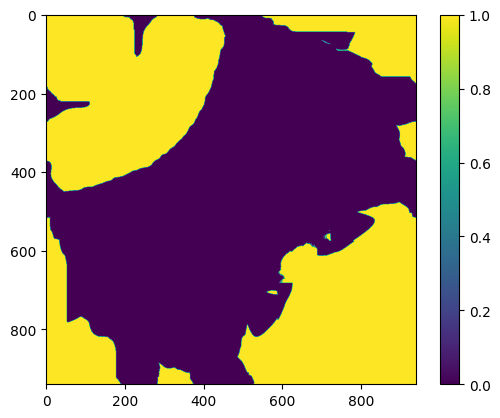

In [68]:
# Export data
filename = 'DOE3x3_topologic_data.mat'
#ex6_data = {'rho_history':rho_history,'FoM_history':FoM_history}
#scipy.io.savemat(filename,ex6_data)
rho2 = rho.detach()
#rho2[rho2>0.5] = 1
#rho2[rho2<0.5] = 0
print(objective_function(rho2).cpu().numpy())
# Plot
print(f'THK = {layer0_thickness}')
print_order(rho2,layer0_thickness)
plt.imshow(rho2.cpu().numpy())
plt.colorbar()
plt.show()

In [69]:
# Field calculation
z = torch.linspace(-500,1500,501,device=device)
z_axis = z.cpu()

rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
rho_tilda = 1/2 + torch.tanh(2*beta[-1]*rho.detach()-beta[-1])/(2*np.math.tanh(beta[-1]))

order = [15,8]

sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
sim.add_input_layer(eps=substrate_eps)
sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
layer0_eps = rho_tilda*silicon_eps + (1.-rho_tilda)
sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
sim.solve_global_smatrix()

NameError: name 'g_fft' is not defined

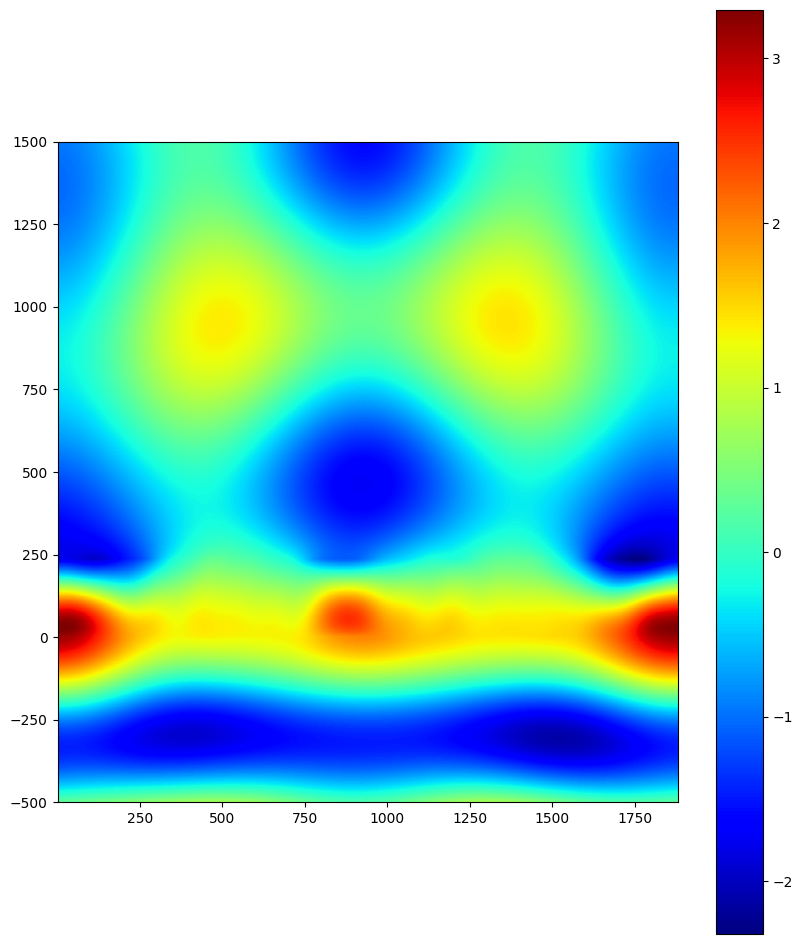

In [ ]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[1.,0.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Xpol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('DOE3x3_data_Xpol_data.mat',ex6_Xpol_data)

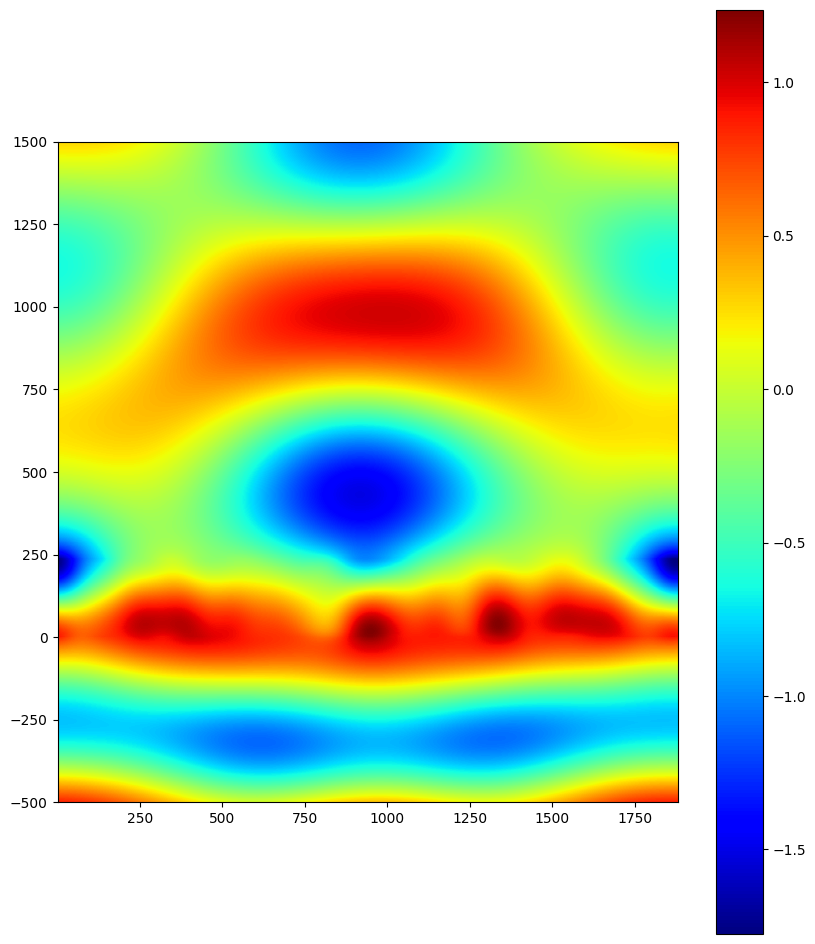

In [ ]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[0.,1.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Ypol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('DOE3x3_data_Ypol_data.mat',ex6_Ypol_data)